# Empirical Test Statistics

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pyhf

Here we define the statistical model we will study

In [38]:
model = pyhf.simplemodels.hepdata_like([10.],[100.],[10.])

The test statistics based on the profile likelihood described in `arXiv:1007.1727` cover scanarios for both 

* bounded models (e.g. POIs constrained to values >= 00
* unbounded models (unconstrained range for POI values)

We set up the bounds for the fit as follows

In [17]:
unbounded_bounds = model.config.suggested_bounds()
unbounded_bounds[model.config.poi_index] = (-10,10)


bounded_bounds = model.config.suggested_bounds()

Next we draw some synthetic datasets (also referrerd to as "toys")

In [66]:
toys = model.make_pdf(pyhf.tensorlib.astensor([1.,1.])).sample((1000,))

In the asymptotic treatment the test statistics are described as a function of the data's best-fit POI value $\hat\mu$. 

So let's run some fits so we can plots the empirical test statistics against $\hat\mu$ to observed the emergence of the asymptotic behavior.

In [67]:
results = [pyhf.infer.mle.fit(t,model, par_bounds = unbounded_bounds, return_fitted_val = True) for t in toys]

pars = np.asarray([r[0] for r in results])
vals = np.asarray([r[1] for r in results])
vals = np.asarray([pyhf.tensorlib.astensor(v) for i,v in enumerate(vals)])

We can now calculate all four test statistics described in `arXiv:1007.1727`

In [68]:
tmu = np.asarray(
    [pyhf.infer.test_statistics.tmu(
        1.0,t,model,
        init_pars = model.config.suggested_init(),
        par_bounds = unbounded_bounds
    ) for t in toys]
)

In [69]:
tmutilde = np.asarray(
    [pyhf.infer.test_statistics.tmu_tilde(
        1.0,t,model,
        init_pars = model.config.suggested_init(),
        par_bounds = bounded_bounds
    ) for t in toys]
)

In [70]:
qmu = np.asarray(
    [pyhf.infer.test_statistics.qmu(
        1.0,t,model,
        init_pars = model.config.suggested_init(),
        par_bounds = unbounded_bounds
    ) for t in toys]
)

In [71]:
qmutilde = np.asarray(
    [pyhf.infer.test_statistics.qmu_tilde(
        1.0,t,model,
        init_pars = model.config.suggested_init(),
        par_bounds = bounded_bounds
    ) for t in toys]
)

Let's Plot all the test statistics we have computed

In [105]:
muhat = pars[:,model.config.poi_index]
muhat_sigma = np.std(muhat)

We can check the asymptotic assumption that $\hat{\mu}$ is distributed normally around it's true value $\mu' = 1$

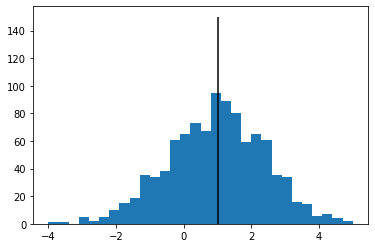

In [93]:
plt.hist(muhat, bins = np.linspace(-4,5,31))
plt.vlines(1,0,150)

Here we define the asymptotic test statistics:

In [123]:
def tmu_asymp(mutest,muhat,sigma):
    return (mutest-muhat)**2/sigma**2

def tmutilde_asymp(mutest,muhat,sigma):
    a = (mutest-muhat)**2/sigma**2
    b = (mutest-muhat)**2/sigma**2 - (0-muhat)**2/sigma**2    
    return np.where(muhat>0,a,b)

def qmu_asymp(mutest,muhat,sigma):
    return np.where(muhat > mutest,np.zeros_like(muhat),tmu_asymp(mutest,muhat,sigma))

def qmutilde_asymp(mutest,muhat,sigma):
    return np.where(muhat > mutest,np.zeros_like(muhat),tmutilde_asymp(mutest,muhat,sigma))

And now we can compare them to the empirical values:

(0.0, 10.0)

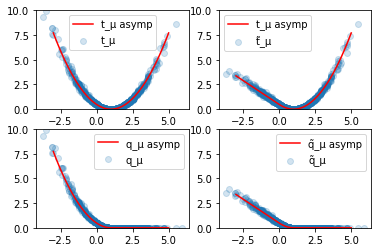

In [126]:
muhat_asymp = np.linspace(-3,5)
f,axarr = plt.subplots(2,2)
axarr[0,0].scatter(muhat,tmu, alpha = 0.2, label = 't_μ')
axarr[0,0].plot(muhat_asymp,tmu_asymp(1.0,muhat_asymp,muhat_sigma), label = 't_μ asymp', c = 'r')
axarr[0,0].legend()
axarr[0,0].set_ylim(0,10)
axarr[0,1].scatter(muhat,tmutilde, alpha = 0.2, label = 't̃_μ')
axarr[0,1].plot(muhat_asymp,tmutilde_asymp(1.0,muhat_asymp,muhat_sigma), label = 't_μ asymp', c = 'r')
axarr[0,1].legend()
axarr[0,1].set_ylim(0,10)
axarr[1,0].scatter(muhat,qmu, alpha = 0.2, label = 'q_μ')
axarr[1,0].plot(muhat_asymp,qmu_asymp(1.0,muhat_asymp,muhat_sigma), label = 'q_μ asymp', c = 'r')
axarr[1,0].legend()
axarr[1,0].set_ylim(0,10)
axarr[1,1].scatter(muhat,qmutilde, alpha = 0.2, label = 'q̃_μ')
axarr[1,1].plot(muhat_asymp,qmutilde_asymp(1.0,muhat_asymp,muhat_sigma), label = 'q̃_μ asymp', c = 'r')
axarr[1,1].legend()
axarr[1,1].set_ylim(0,10)